In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from rdkit import Chem
from rdkit.Chem import Draw

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from mordred import Calculator, descriptors

In [2]:
train = pd.read_csv(r"C:\data\kaggle_Open_Polymer_2025\dataset_dawnload_from_kaggle\train.csv")

In [3]:
train.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN


In [5]:
train.notna().sum()

id         7973
SMILES     7973
Tg          511
FFV        7030
Tc          737
Density     613
Rg          614
dtype: int64

In [7]:
train_tg = train[["SMILES", "Tg"]].dropna().reset_index(drop=True)
train_tg.shape

(511, 2)

In [9]:
smiles_list = train_tg["SMILES"].tolist()

# Mordred記述子の準備（すべての記述子、3D記述子は除外）
calc = Calculator(descriptors, ignore_3D=True)

# 分子の数
print('分子の数 :', len(smiles_list))

分子の数 : 511


In [10]:
# 記述子の計算
mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
descriptors_train = calc.pandas(mols)  # DataFrame形式で取得

  1%|          | 6/511 [00:03<03:15,  2.58it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 10%|▉         | 49/511 [00:04<00:21, 21.26it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19%|█▉        | 98/511 [00:06<00:18, 22.28it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 41%|████      | 209/511 [00:10<00:07, 39.46it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 42%|████▏     | 216/511 [00:11<00:13, 21.46it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 75%|███████▍  | 381/511 [00:16<00:03, 34.45it/s]

c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 511/511 [00:21<00:00, 23.75it/s]


c:\data\titnic\venv312\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [12]:
descriptors_train.shape

(511, 1613)

In [13]:
def select_col(df):
    # 初期のカラム数を表示
    print(f"Initial number of columns: {df.shape}")
    
    # 0. データフレームを数値型の列だけにする
    df = df.select_dtypes(include=['number'])
    print(f"After selecting numeric columns: {df.shape}")
    
    # 1. 無限大な値をNaNに置換
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 2. 明らかに大きすぎる値（float32オーバーフロー）をNaNにする
    max_float32 = np.finfo(np.float32).max
    df = df.where(df.abs() <= max_float32, np.nan)

    # 3. 欠損値のあるカラムを削除
    df = df.dropna(axis=1)
    print(f"After dropping columns with missing values: {df.shape}")

    # 4. 標準偏差が0（すべての値が同じ）のカラムを削除
    df = df.loc[:, df.std(numeric_only=True) != 0]
    print(f"After dropping columns with zero standard deviation: {df.shape}")

    return df

descriptors_final = select_col(descriptors_train)

Initial number of columns: (511, 1613)
After selecting numeric columns: (511, 725)
After dropping columns with missing values: (511, 696)
After dropping columns with zero standard deviation: (511, 538)


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [17]:
# Random Forest
rf_params = {"max_depth": 10,
             "criterion":"squared_error",
             "max_features":"sqrt",
             "min_samples_leaf": 1,
             "min_samples_split": 5,
             "n_estimators": 100,
             "n_jobs":1,
             "bootstrap":True,
             "random_state": 42
            }

def RF_cv(input_x, input_y, params, n_split=5):

    metrics = []
    imp = pd.DataFrame()
    models = []
    oof_preds = np.zeros(len(input_x))

    cv = list(KFold(n_splits=n_split, shuffle=True, random_state=42).split(input_x, input_y))

    for nfold in range(n_split):
        print("-" * 20, f"Fold {nfold}", "-" * 20)
        idx_tr, idx_va = cv[nfold]
        X_tr, y_tr = input_x.iloc[idx_tr], input_y.iloc[idx_tr]
        X_va, y_va = input_x.iloc[idx_va], input_y.iloc[idx_va]

        print(X_tr.shape, y_tr.shape)
        print(X_va.shape, y_va.shape)

        model = RandomForestRegressor(**params)
        model.fit(X_tr, y_tr,)
        models.append(model)

        y_tr_pred = model.predict(X_tr)
        y_va_pred = model.predict(X_va)
        metric_train = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
        metric_test = np.sqrt(mean_squared_error(y_va, y_va_pred))
        metrics.append([nfold, metric_train, metric_test])
        
        oof_preds[idx_va] = y_va_pred

        _imp = pd.DataFrame({
            "col": X_tr.columns,
            "imp": model.feature_importances_,
            "nfold": nfold
        })
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print("=" * 20, "CV Results", "=" * 20)

    metrics = np.array(metrics)
    print(metrics)
    print(f"[cv] train: {metrics[:,1].mean():.5f}±{metrics[:,1].std():.5f}, "
          f"test: {metrics[:,2].mean():.5f}±{metrics[:,2].std():.5f}")

    imp = imp.groupby("col")["imp"].agg(["mean", "std"]).reset_index()
    imp.columns = ["col", "imp", "imp_std"]

    return models, imp, metrics, oof_preds

In [20]:
X = descriptors_final
y = train_tg["Tg"]

models, imp, metrics, oof_preds = RF_cv(X, y, rf_params, n_split=5)

-------------------- Fold 0 --------------------
(408, 538) (408,)
(103, 538) (103,)
-------------------- Fold 1 --------------------
(409, 538) (409,)
(102, 538) (102,)
-------------------- Fold 2 --------------------
(409, 538) (409,)
(102, 538) (102,)
-------------------- Fold 3 --------------------
(409, 538) (409,)
(102, 538) (102,)
-------------------- Fold 4 --------------------
(409, 538) (409,)
(102, 538) (102,)
==================== CV Results ====================
[[ 0.         30.45945479 69.31744017]
 [ 1.         29.8563894  75.4707046 ]
 [ 2.         30.66589281 69.6687436 ]
 [ 3.         30.78438662 56.85699848]
 [ 4.         30.90892579 61.28648663]]
[cv] train: 30.53501±0.37023, test: 66.52007±6.61239


In [21]:
def evaluate_and_plot(tg_train, oof_preds_tg, figsize=(4, 4)):

    # 評価指標の出力
    print('r^2 for training data :', r2_score(tg_train, oof_preds_tg))
    print('RMSE for training data :', np.sqrt(mean_squared_error(tg_train, oof_preds_tg)))
    print('MAE for training data :', mean_absolute_error(tg_train, oof_preds_tg))

    # 実測値 vs. 推定値のプロット
    plt.figure(figsize=figsize)
    plt.scatter(tg_train, oof_preds_tg, c='blue')

    y_max = max(tg_train.max(), oof_preds_tg.max())
    y_min = min(tg_train.min(), oof_preds_tg.min())

    buffer = 0.05 * (y_max - y_min)
    plt.plot([y_min - buffer, y_max + buffer],
             [y_min - buffer, y_max + buffer], 'k-')
    plt.xlim(y_min - buffer, y_max + buffer)
    plt.ylim(y_min - buffer, y_max + buffer)

    plt.xlabel('actual y')
    plt.ylabel('estimated y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

r^2 for training data : 0.6380404822549245
RMSE for training data : 66.85283923315902
MAE for training data : 51.25426711436167


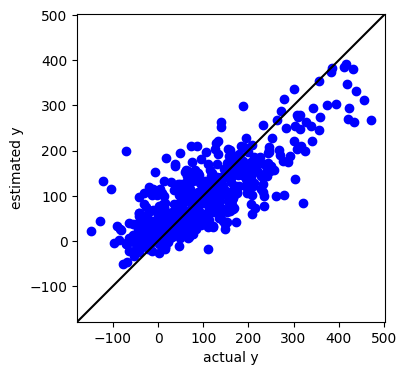

In [27]:
evaluate_and_plot(y, oof_preds)

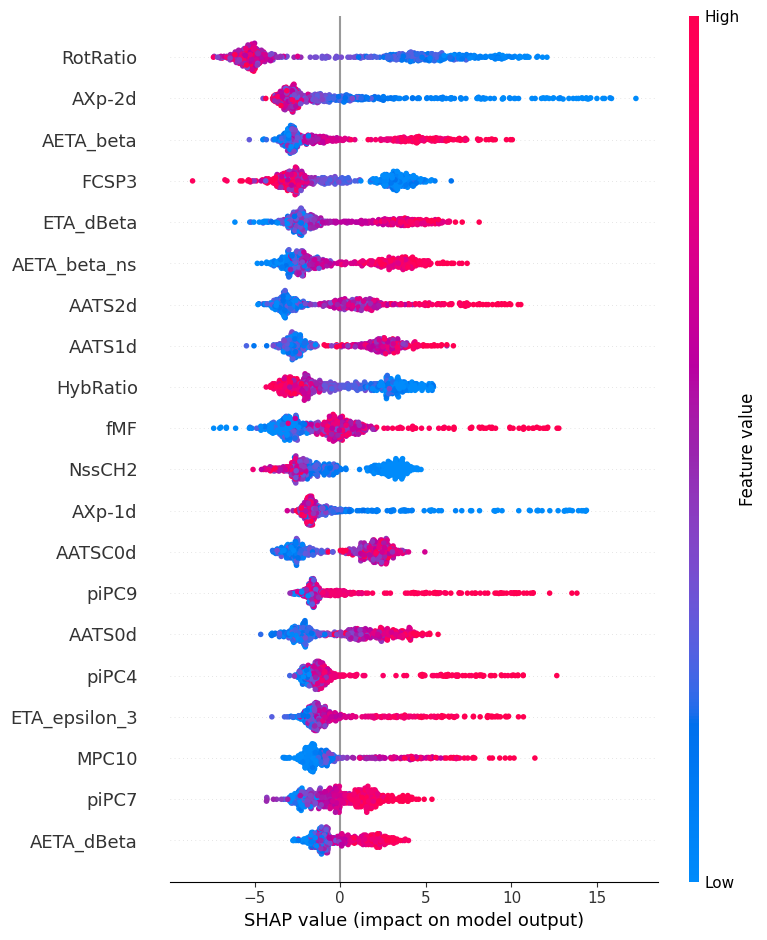

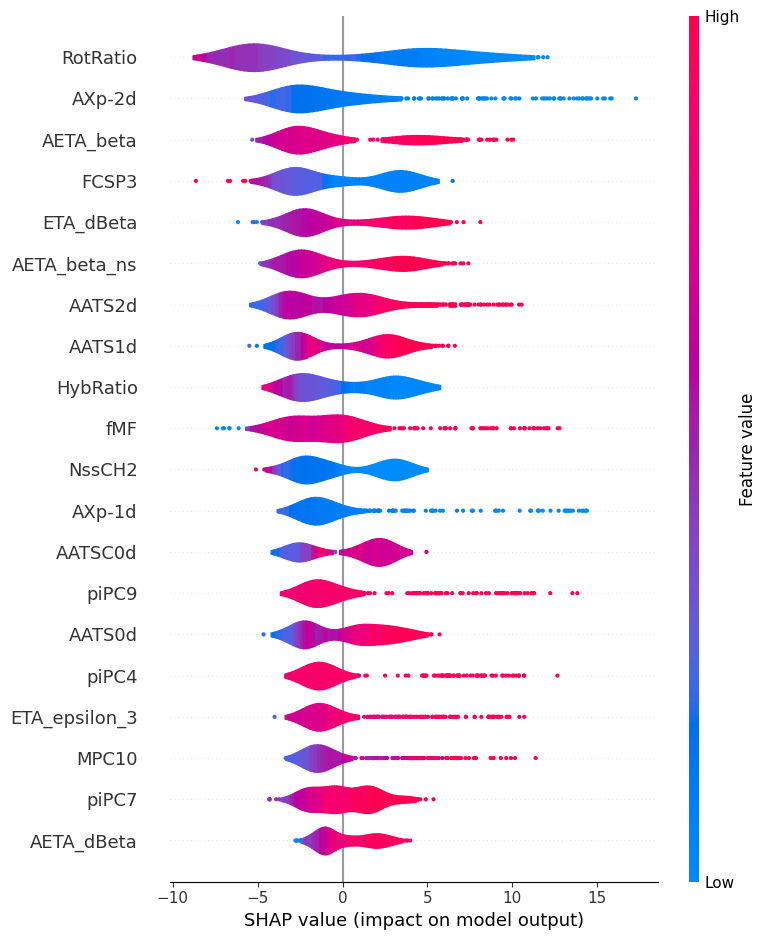

In [30]:
import shap
shap.initjs()

# 例: 1つ目のfoldのモデルを使う
model = models[0]

# SHAPのExplainerを作成（ツリー系モデル専用のTreeExplainerを推奨）
explainer = shap.TreeExplainer(model)

# SHAP値を計算（検証データに対して）
# → foldごとにやりたいなら idx_va を保存しておく必要あり
shap_values = explainer.shap_values(X)

# --- 可視化 ---
# 特徴量全体の重要度を要約（棒グラフ風）
shap.summary_plot(shap_values, X)

# 各サンプルにおける寄与を可視化（バイオリン図）
shap.summary_plot(shap_values, X, plot_type="violin")

# 個別サンプル（例: 0番目）の予測を解釈
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


In [ ]:
# shap_values は Explainer().shap_values(X) の出力（1つのサンプル分）
# expected_value はベースライン（平均予測値）

i = 0  # 確認したいサンプルのインデックス

# shap_values が numpy array の場合
shap_values_sample = shap_values[i]

# 特徴量名
feature_names = X.columns

# サンプルの特徴量値
feature_values = X.iloc[i]

# DataFrame化
df_shap = pd.DataFrame({
    "feature": feature_names,
    "value": feature_values,
    "shap_value": shap_values_sample
}).sort_values("shap_value", ascending=False)

print(df_shap.head(10))# 上位10特徴量
print("===" * 20)
print(df_shap.tail(10))

                 feature      value  shap_value
AMID_N            AMID_N   0.384207    3.029149
SLogP              SLogP  -2.262900    2.364770
VSA_EState1  VSA_EState1  -0.357391    1.923205
SssCH2            SssCH2   0.062364    1.798099
SMR_VSA3        SMR_VSA3  16.367245    1.653191
SlogP_VSA1    SlogP_VSA1  16.367245    1.637566
JGI2                JGI2   0.117647    1.399431
SssNH              SssNH   7.942188    1.368502
SIC1                SIC1   0.676710    1.283258
AATSC0d          AATSC0d   0.557692    1.273032
                   feature     value  shap_value
HybRatio          HybRatio  0.571429   -2.229688
AETA_beta_ns  AETA_beta_ns  0.300000   -2.284835
AXp-2d              AXp-2d  0.353914   -2.482420
ETA_dBeta        ETA_dBeta -5.000000   -2.498213
FCSP3                FCSP3  0.571429   -2.555502
AATS1d              AATS1d  3.360000   -2.681123
AETA_beta        AETA_beta  0.933333   -2.790813
AATS2d              AATS2d  2.761905   -2.801863
fMF                    fMF  0.0

In [44]:
# 例: 1番目のfoldのモデルを使用
model = models[0]

# shap値の計算
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# あるサンプルを選択（例：0番目のサンプル）
i = 0
expected_value = explainer.expected_value.item()
shap_sum = np.sum(shap_values[i])
prediction = model.predict(X.iloc[[i]])[0]

print(f"expected_value      : {expected_value:.4f}")
print(f"sum(shap_values[i]) : {shap_sum:.4f}")
print(f"expected + sum      : {expected_value + shap_sum:.4f}")
print(f"model prediction    : {prediction:.4f}")


expected_value      : 99.6092
sum(shap_values[i]) : -40.8052
expected + sum      : 58.8041
model prediction    : 58.8041
